<a href="https://colab.research.google.com/github/sasha-kap/Programming/blob/master/LightGBM_Reproduce_Poisson_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
print(f"The LightGBM version is {lgb.__version__}.")

The LightGBM version is 2.2.3.


#### Define objective and evaluation functions






In [3]:
def poisson_loss(y_true, y_pred):
    """Custom objective function that reproduces LightGBM's built-in Poisson
    objective.

    Parameters:
    -----------
    y_true : array-like of shape = [n_samples]
        The target values
    y_pred : array-like of shape = [n_samples]
        The predicted values.
        Predicted values are returned before any transformation, e.g. they are
        raw margin instead of probability of positive class for binary task.

    Returns:
    --------
    grad : array-like of shape = [n_samples]
        The value of the first order derivative (gradient) of the loss with
        respect to the elements of y_pred for each sample point.
    hess : array-like of shape = [n_samples]
        The value of the second order derivative (Hessian) of the loss with
        respect to the elements of y_pred for each sample point.

    Notes:
    ------
    0.7 is the default value of poisson_max_delta_step parameter used for
    Poisson regression to safeguard optimization
    (https://lightgbm.readthedocs.io/en/latest/Parameters.html)

    This 0.7 value enters the hessian in this manner in the library's C++ code
    (https://github.com/microsoft/LightGBM/blob/master/src/objective/regression_objective.hpp#L446)
    """
    # loss here is the negative log-likelihood for Poisson regression
    loss = np.exp(y_pred) - y_true * y_pred
    grad = np.exp(y_pred) - y_true
    hess = np.exp(y_pred + 0.7)

    return grad, hess

In [4]:
def poisson_eval_metric(y_true, y_pred):
    """Custom evaluation function that reproduces the results of LightGBM's
    built-in Poisson evaluation metric (negative log-likelihood).

    Parameters:
    -----------
    y_true : array-like of shape = [n_samples]
        The target values
    y_pred : array-like of shape = [n_samples]
        The predicted values.
        Predicted values are returned before any transformation, e.g. they are
        raw margin instead of probability of positive class for binary task.

    Returns:
    --------
    eval_name : str
        The name of evaluation function (without whitespace)
    eval_result : float
        The eval result
    is_higher_better : bool
        Is eval result higher bettr, e.g., AUC is is_higher_better
    """
    return 'poisson_metric', np.mean(np.exp(y_pred) - y_true * y_pred, axis=0), False

#### Create dataset for model

In [5]:
n = 1000

rng = np.random.RandomState(42)

x1 = rng.uniform(0, 4, n)
x2 = rng.uniform(0, 1.5, n)
x3 = rng.normal(0, 3, n)

mu = np.exp(1 - 0.2 * x1 - 0.3 * x2 - 0.01 * x3)
y = rng.poisson(mu, size=n)

df = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2, 'x3': x3})
df.head()

,y,x1,x2,x3
0,3,1.498160,0.277699,-2.633948
1,1,3.802857,0.812851,-2.480641
2,2,2.927976,1.309419,-0.679437
3,0,2.394634,1.098337,1.102097
4,1,0.624075,1.209842,2.740754


In [6]:
df['y'].value_counts().sort_index()

0    241
1    341
2    221
3    126
4     45
5     19
6      7
Name: y, dtype: int64

#### Run Poisson regression with built-in Poisson objective and evaluation functions

In [7]:
model = lgb.LGBMRegressor(
    objective='poisson',
    learning_rate=0.1,
    n_estimators=100
)

# using LightGBM's scikit-learn API
# to make the results match, the init_score is set to the log of the mean of
# the target values.
model.fit(
    df[['x1', 'x2', 'x3']].to_numpy(),
    df['y'].to_numpy(),
    init_score=np.repeat([np.log(np.mean(df['y']))], len(df['y'])),
    eval_set=[(df[['x1', 'x2', 'x3']], df['y'].to_numpy())],
    eval_metric='poisson',
    eval_names=['Train'],
    verbose=20,
)

[20]	Train's poisson: 0.879023
[40]	Train's poisson: 0.819204
[60]	Train's poisson: 0.77684
[80]	Train's poisson: 0.74138
[100]	Train's poisson: 0.71657


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective='poisson',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

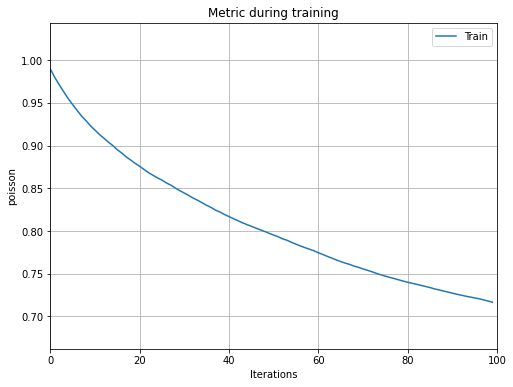

In [8]:
# Plot Poisson evaluation metric against boosting iterations
lgb.plot_metric(model, metric='poisson', figsize=(8,6))
plt.show()

#### Run Poisson regression utilizing custom Poisson objective and evaluation functions

In [9]:
model = lgb.LGBMRegressor(
    objective=poisson_loss,
    learning_rate=0.1,
    n_estimators=100
)

# using LightGBM's scikit-learn API
# to make the results match, the init_score is set to the log of the mean of
# the target values.
model.fit(
    df[['x1', 'x2', 'x3']].to_numpy(),
    df['y'].to_numpy(),
    init_score=np.repeat([np.log(np.mean(df['y']))], len(df['y'])),
    eval_set=[(df[['x1', 'x2', 'x3']], df['y'].to_numpy())],
    eval_metric=poisson_eval_metric,
    eval_names=['Train'],
    verbose=20,
)

[20]	Train's poisson_metric: 0.879023
[40]	Train's poisson_metric: 0.819204
[60]	Train's poisson_metric: 0.77684
[80]	Train's poisson_metric: 0.74138
[100]	Train's poisson_metric: 0.71657


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=<function poisson_loss at 0x7fe082c19050>,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

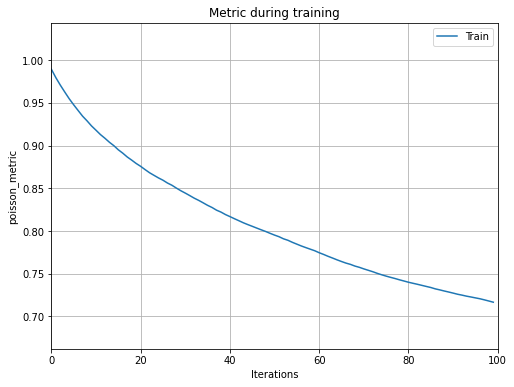

In [11]:
# Plot Poisson evaluation metric against boosting iterations
lgb.plot_metric(model, metric='poisson_metric', figsize=(8,6))
plt.show()